# Core task 2 : code to get you started

This notebook demonstrates how to use the network_spreading_models toolbox to fit the NDM and FKPP models to some target data.
First, we import the relevant libraries.

If you have set up the environment correctly, the following cell should run without any errors.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from nsm_toolbox.src import network_diffusion_model, FKPP_model
from nsm_toolbox.src.find_optimal_timepoint import find_optimal_timepoint

from nsm_toolbox.src.ModelSelection import ModelSelection

Next, we will load in the target data, which is regional tau-PET SUVR data from the ADNI dataset, averaged across individuals with amyloid and tau pathology.

We min-max normalise the data to the range [0,1], as this is required for the model fitting.

In [2]:
# load in target data
tau = pd.read_csv("data/PET/tau_ab+_tau+.csv", names=["region", "suvr"], header=0)
target_data = tau["suvr"].values

# remove the subcortical regions, since these are affected by off-target binding of the tau-PET tracer
CORT_IDX = np.concatenate([np.arange(34), np.arange(49, 83)])
target_data = target_data[CORT_IDX]

def normalise_data(data):
    ''' min-max normalise the data '''
    return (data - np.min(data)) / (np.max(data) - np.min(data))

target_data = normalise_data(target_data)

# load in the reference list
region_list = pd.read_csv( "data/TauRegionList.csv")["Raj_label"].tolist()

Now we are ready to fit the models to the data.

We will start with the Network Diffusion Model. For now, we will use one of the connectomes from a single cognitively normal individual.

In [3]:
# the path where the connectome is stored
connectome_path = "data/connectomes/CN/CN_0.csv"

# define the timepoints for our model evaluation
t = np.arange(0, 50, 0.1)

# define gamma: the diffusion constant (we set this to 1 since we are not calibrating our time units to any real-world time)
gamma = 1

# set up our network diffusion model class with the connectome, timepoints, gamma, and reference list
ndm = network_diffusion_model.NDM(connectome_fname=connectome_path,
                                  t=t,
                                  gamma = gamma,
                                  ref_list=region_list)

# find the optimal seed region for our dataset
df, optimal_seed = ndm.optimise_seed_region(target_data)
print(optimal_seed)

# run the model with the optimal parameters (in this case, the seed region) and record model fit
ndm.seed_region = optimal_seed["seed"]
model_output = ndm.run_NDM()

# we use find_optimal_timepoint to scan the model output and find the timepoint that best fits the target data
min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)

{'seed': 'Temporalpole'}


## Model comparison
Dummy example for 5 models each having 100 obeservations using AICc criterion: 

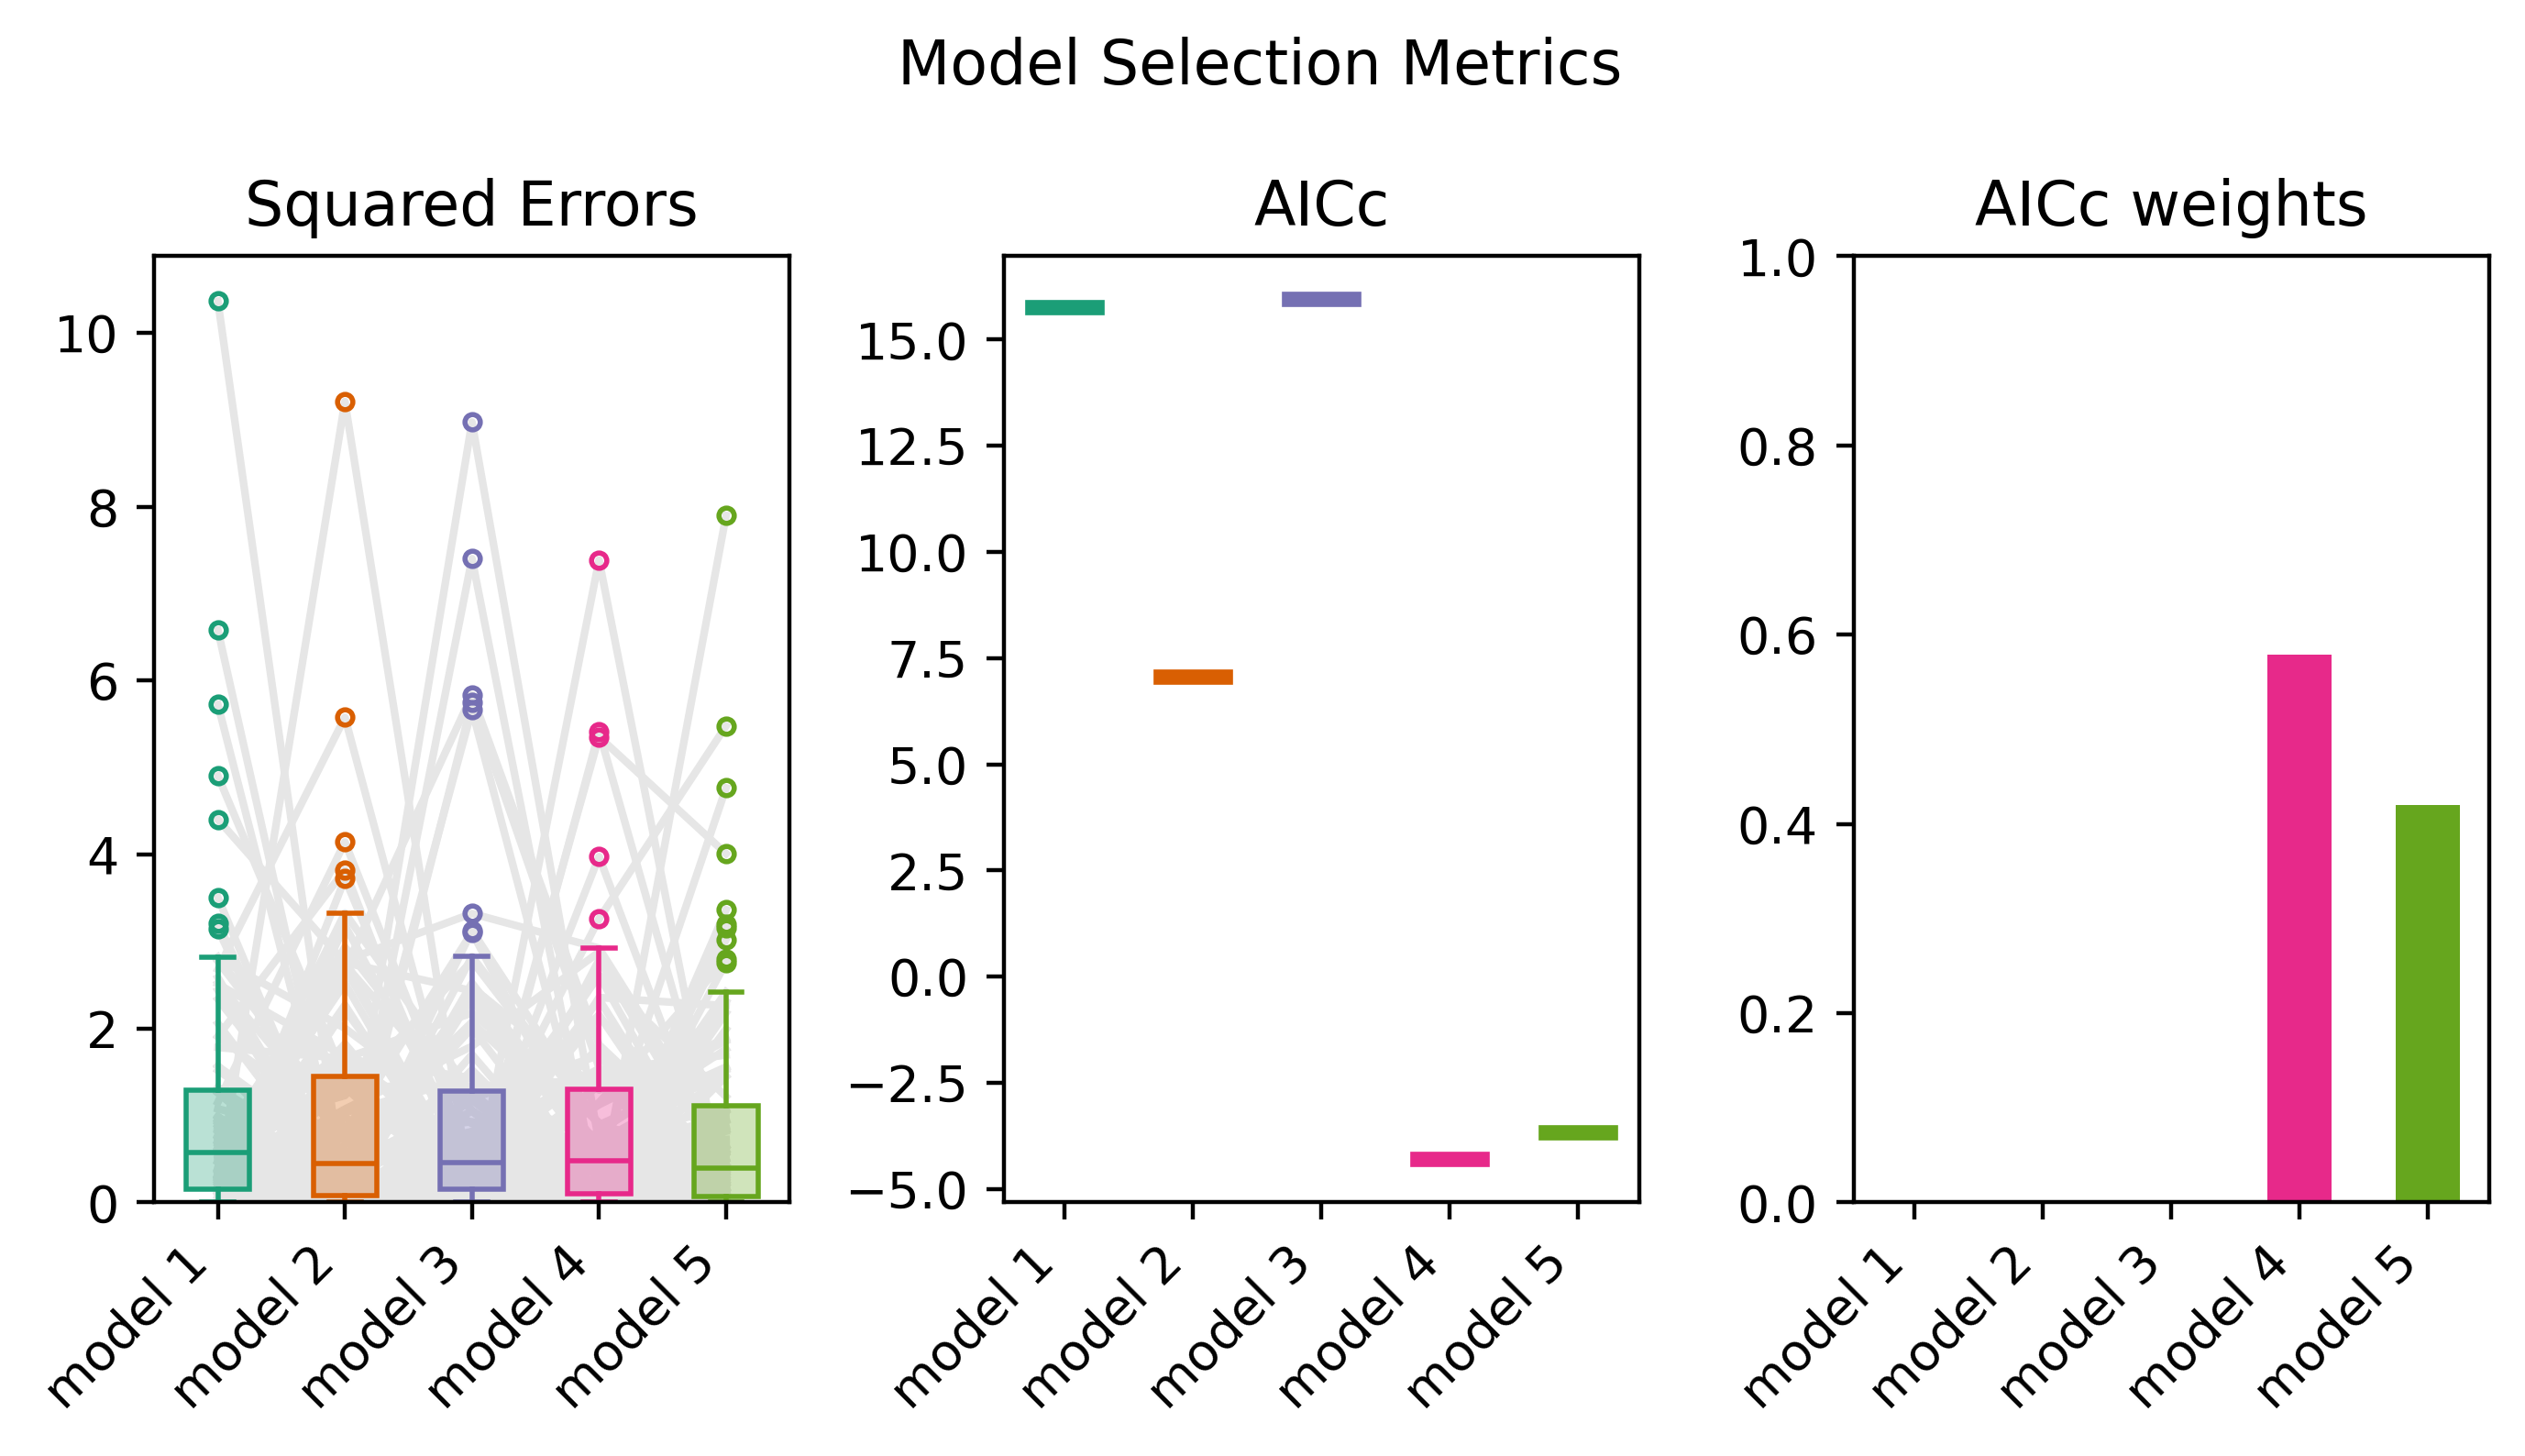

     Model       AICc  AICc weights  rank
0  model 1  15.763917      0.000025     4
1  model 2   7.056415      0.001974     3
2  model 3  15.954310      0.000023     5
3  model 4  -4.303799      0.578363     1
4  model 5  -3.662066      0.419614     2


In [4]:
from nsm_toolbox.src.ModelSelection import ModelSelection

residuals = np.random.normal(size=(100,5))
results = ModelSelection([3,3,4,2,3], 'AICc')(residuals)
print(results)

## Calculate Group-averaged connectomes

In [5]:
groups = ["CN", "EMCI", "LMCI", "DEM"]

# loop over cog. groups
for group in groups:

    # folder path
    group_folder = os.path.join("data", "connectomes", group)

    # list csv files in folder
    connectome_files = [os.path.join(group_folder, f) for f in os.listdir(group_folder) if f.endswith('.csv')]

    # load connectomes
    connectomes = []
    shapes = []
    
    for f in connectome_files:
        matrix = pd.read_csv(f, header=None).values
        shapes.append(matrix.shape)
        connectomes.append(matrix)
    
    # compute averages
    group_avg_connectome = np.mean(np.stack(connectomes, axis=0), axis=0)

    # save the data
    group_avg_path = os.path.join(group_folder, f"group_avg_{group}.csv")
    np.savetxt(group_avg_path, group_avg_connectome, delimiter = ",")

## Run Models

In [22]:
from joblib import Parallel, delayed

def ndm_model(group, t, gamma, target_data, region_list):
    group_avg_path = f"data/connectomes/{group}/group_avg_{group}.csv"
    
    ndm = network_diffusion_model.NDM(connectome_fname = group_avg_path,
                                     t=t, gamma=gamma, ref_list = region_list)
    df_ndm, optimal_seed_ndm = ndm.optimise_seed_region(target_data)

    # set optimal seed & run
    ndm.seed_region = optimal_seed_ndm["seed"]
    ndm_output = ndm.run_NDM()

    # find timepoint
    min_idx_ndm, prediction_ndm, SSE_ndm = find_optimal_timepoint(ndm_output, target_data)

    # compute pearsons corr
    r_ndm = np.corrcoef(prediction_ndm, target_data)[0,1]

    # calculate residuals & AICc for NDM
    ndm_residuals = (target_data - prediction_ndm)
    ndm_num_params = [1]
    # aicc_ndm = ModelSelection(ndm_num_params, 'AICc')(ndm_residuals)

    residuals_df = pd.DataFrame(ndm_residuals, columns=["Residuals"])
    residuals_df["Region"] = region_list[:len(ndm_residuals)]
    residuals_df.to_csv(f"NDM_residuals_{group}.csv", index=False)

    print(f"NDM Results for group {group}:")
    print(optimal_seed_ndm)
    print(min_idx_ndm)
    print(SSE_ndm)
    print(r_ndm)
    print("-" * 40)

    return group, {
        "Group": group,
        "optimal_seed": optimal_seed_ndm,
        "min_timepoint_index": min_idx_ndm,
        "SSE": SSE_ndm,
        "r": r_ndm,
        "prediction": prediction_ndm,
        "df": df_ndm,
        "output": ndm_output
    }

t = np.arange(0, 50, 0.1)
gamma = 1

ndm_results = {}

for group in groups:
    group_label, results = ndm_model(group, t, gamma, target_data, region_list)
    ndm_results[group_label] = results

NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
NDM Results for group EMCI:
{'seed': 'Inferiortemporal'}
42
2.5197649294970526
0.7192431127956975
----------------------------------------
NDM Results for group LMCI:
{'seed': 'Inferiortemporal'}
41
2.622799604895122
0.7177903179218379
----------------------------------------
NDM Results for group DEM:
{'seed': 'Inferiortemporal'}
43
2.5677088851455947
0.7141830528085821
----------------------------------------


/Users/ariannaparada/Desktop/UCL/Masters/CMBI/CMBI_project_clean/nsm_toolbox/src/plot_functions.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


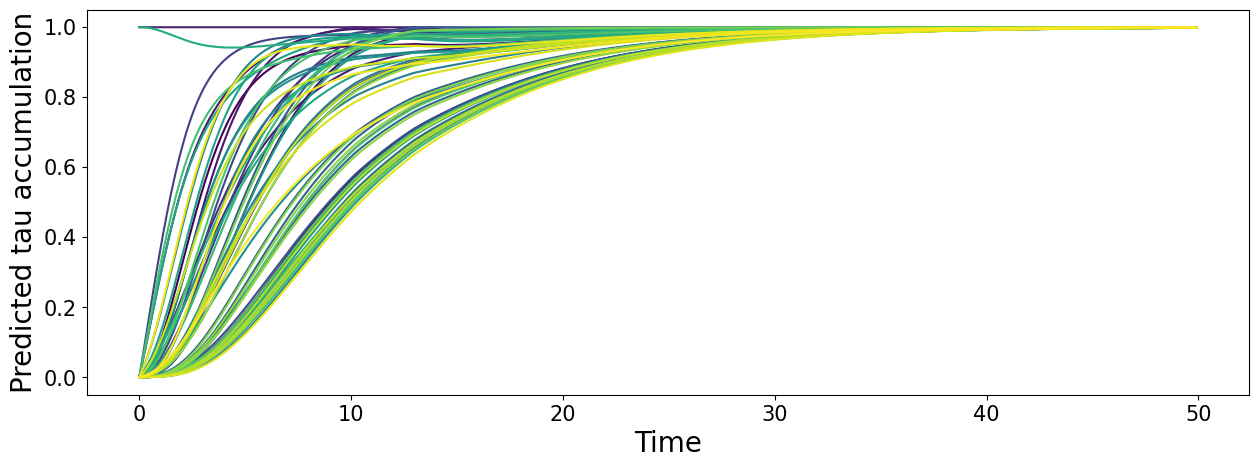

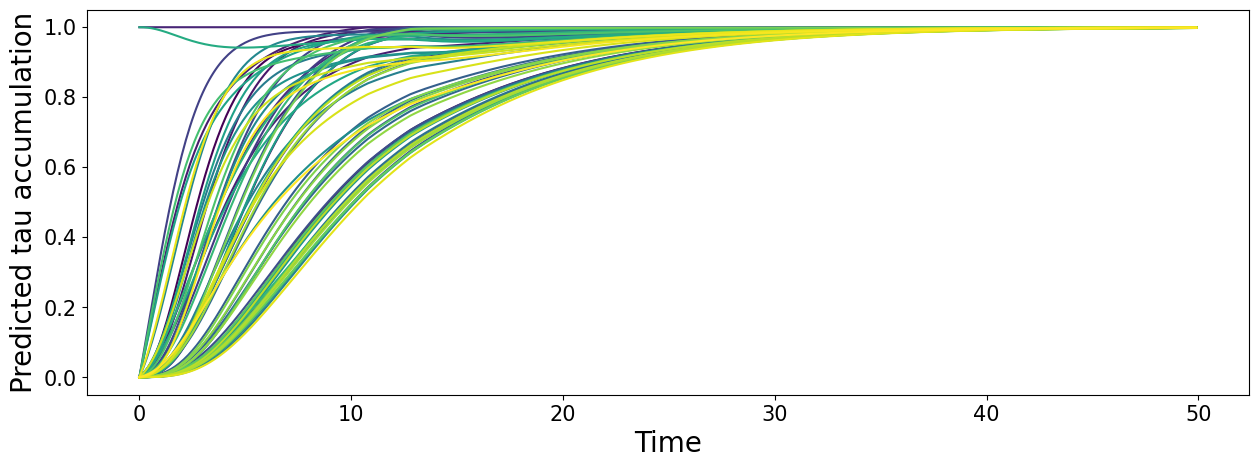

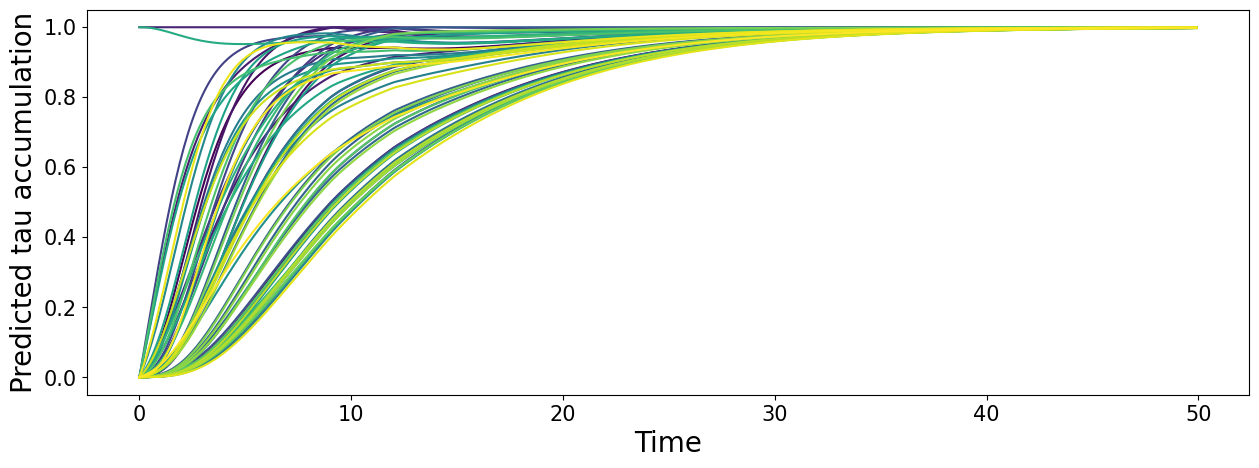

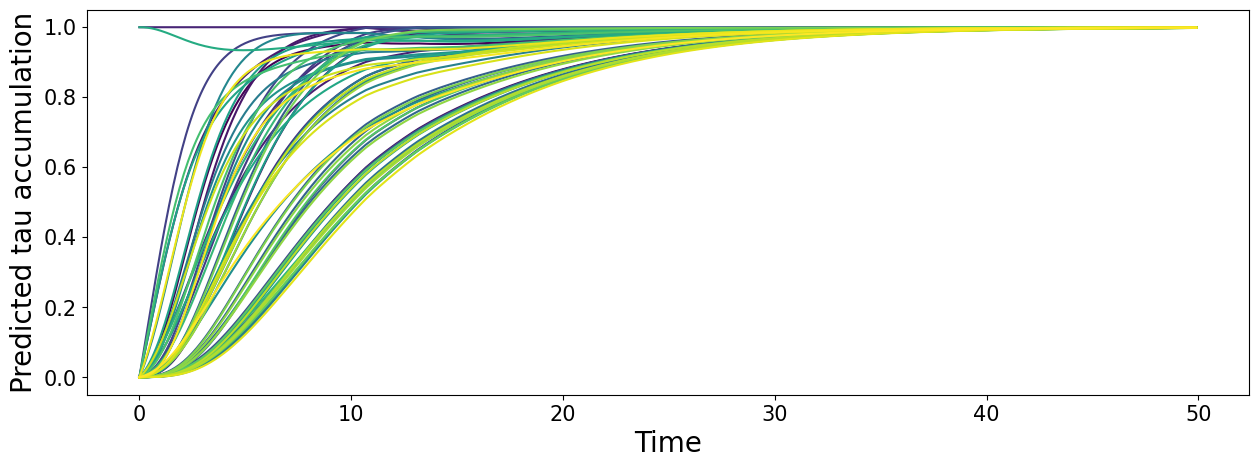

In [31]:
from nsm_toolbox.src.plot_functions import plot_seed_correlations, plot_times_series

for group in groups:
    r_val = ndm_results[group]["r"]
    seed_region = ndm_results[group]["optimal_seed"]["seed"]

    #plot_seed_correlations(ndm_results[group]["df"], cmap="viridis")


    plot_times_series(ndm_results[group]["output"], t, cmap="viridis")



In [32]:
def fkpp_model(group, t, gamma, target_data, region_list, seed_list=None, n_calls=200, n_initial_points=128):
    group_avg_path = f"data/connectomes/{group}/group_avg_{group}.csv"
    
    # initialise
    fkpp = FKPP_model.FKPP(connectome_fname=group_avg_path,
                            t=t,
                            gamma=gamma,
                            ref_list=region_list)

    # optimal seed
    df_fkpp, optimal_params = fkpp.optimise_fkpp(target_data)

    optimal_seed = {"seed": optimal_params["seed"]}
    optimal_alpha = optimal_params["alpha"]


    # optimal params & run
    fkpp.seed_region = optimal_seed["seed"]
    fkpp.alpha = optimal_alpha
    fkpp_output = fkpp.run_FKPP()

    # optimal timepoint
    min_idx_fkpp, prediction_fkpp, SSE_fkpp = find_optimal_timepoint(fkpp_output, target_data)

    # pearsons corr
    r_fkpp = np.corrcoef(prediction_fkpp, target_data)[0,1]

    # calculate residuals & AICc for FKPP
    fkpp_residuals = (target_data - prediction_fkpp)
    fkpp_num_params = [3]

    residuals_df = pd.DataFrame(fkpp_residuals, columns=["Residuals"])
    residuals_df["Region"] = region_list[:len(fkpp_residuals)]
    residuals_df.to_csv(f"FKPP_residuals_{group}.csv", index=False)
    
    print(f"FKPP Results for group {group}:")
    print(optimal_seed)
    print(optimal_alpha)
    print(min_idx_fkpp)
    print(SSE_fkpp)
    print(r_fkpp)
    print("-" * 40)

    return group, {
        "Group": group,
        "optimal_seed": optimal_seed,
        "optimal_alpha": optimal_alpha,
        "min_timepoint_index": min_idx_fkpp,
        "SSE": SSE_fkpp,
        "r": r_fkpp,
        "prediction": prediction_fkpp,
        "df": df_fkpp,
        "output": fkpp_output
    }

t = np.arange(0, 50, 0.1)
gamma = 1

fkpp_results = {}

for group in groups:
    group_label, results = fkpp_model(group, t, gamma, target_data, region_list)
    fkpp_results[group_label] = results


FKPP Results for group CN:
{'seed': np.str_('Inferiortemporal')}
0.4608532996567601
77
2.2505106070104826
0.6666013202387707
----------------------------------------
FKPP Results for group CN:
{'seed': np.str_('Inferiortemporal')}
0.45219687612550163
76
2.25134902020991
0.6705249685057807
----------------------------------------
FKPP Results for group EMCI:
{'seed': np.str_('Inferiortemporal')}
0.45810349213473817
77
2.285543851293737
0.6600164069355067
----------------------------------------
FKPP Results for group LMCI:
{'seed': np.str_('Inferiortemporal')}
0.47366395048874627
78
2.337031906587337
0.6498619907838896
----------------------------------------
FKPP Results for group DEM:
{'seed': np.str_('Temporalpole')}
0.4568733081516095
101
2.339485220573683
0.6249386679175565
----------------------------------------


/Users/ariannaparada/Desktop/UCL/Masters/CMBI/CMBI_project_clean/nsm_toolbox/src/plot_functions.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


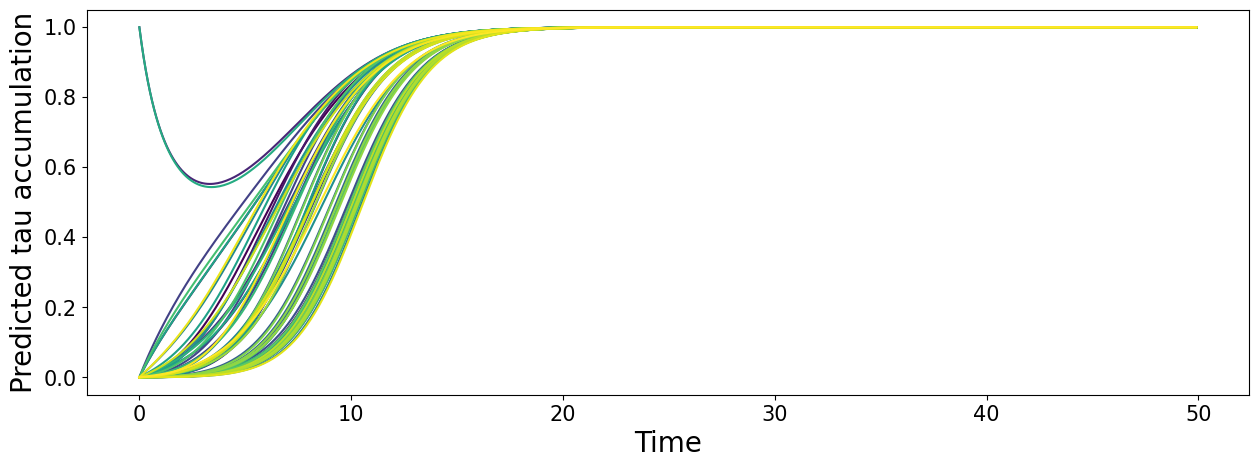

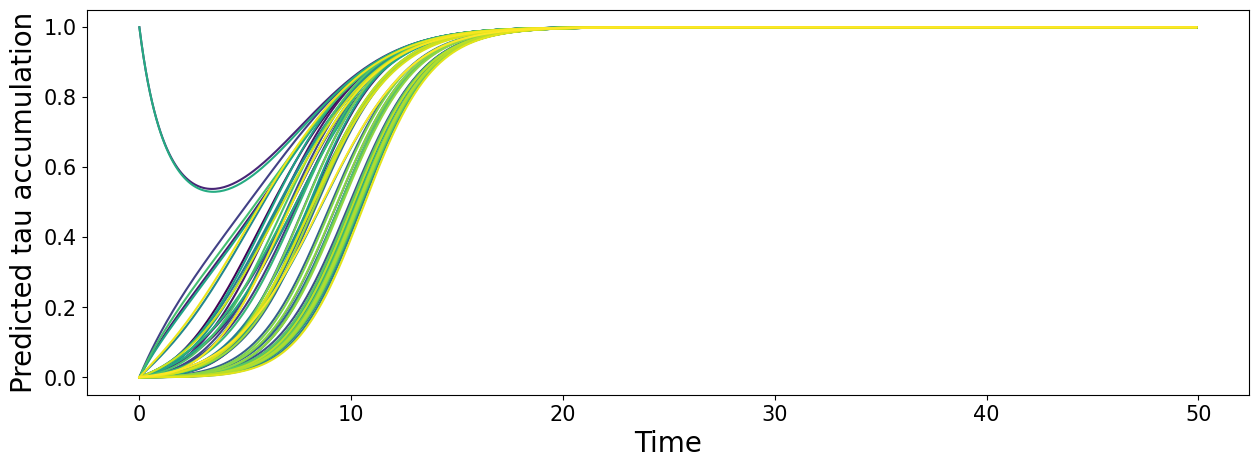

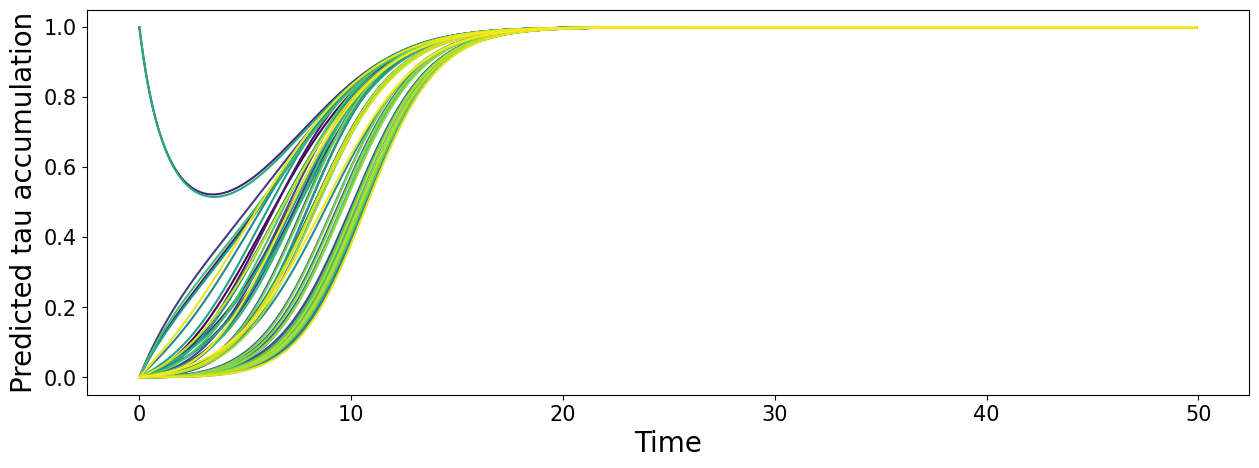

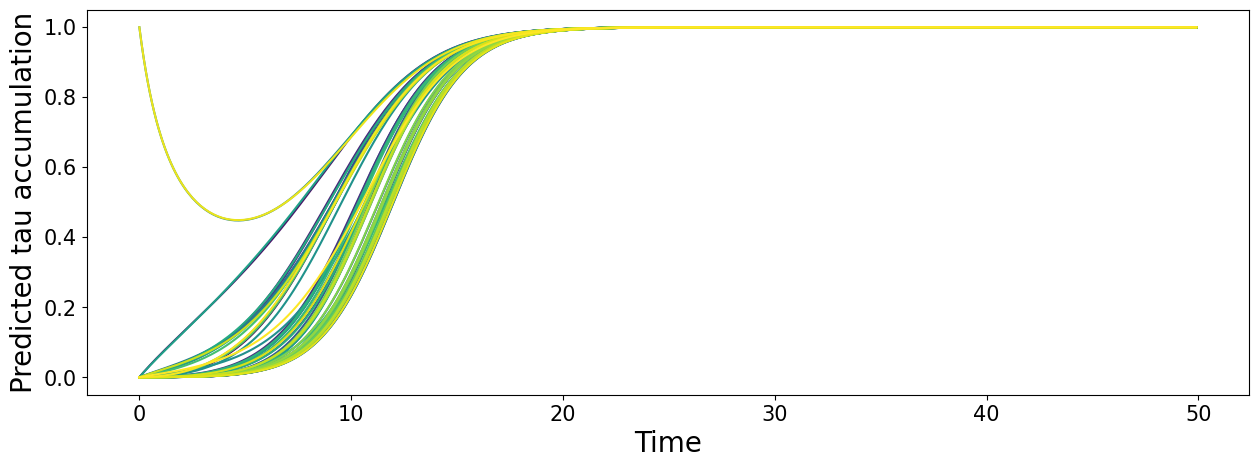

In [33]:
for group in groups:
    r_val = fkpp_results[group]["r"]
    seed_region = fkpp_results[group]["optimal_seed"]["seed"]

    #plot_seed_correlations(fkpp_results[group]["df"], cmap="viridis")


    plot_times_series(fkpp_results[group]["output"], t, cmap="viridis")

## Comparison

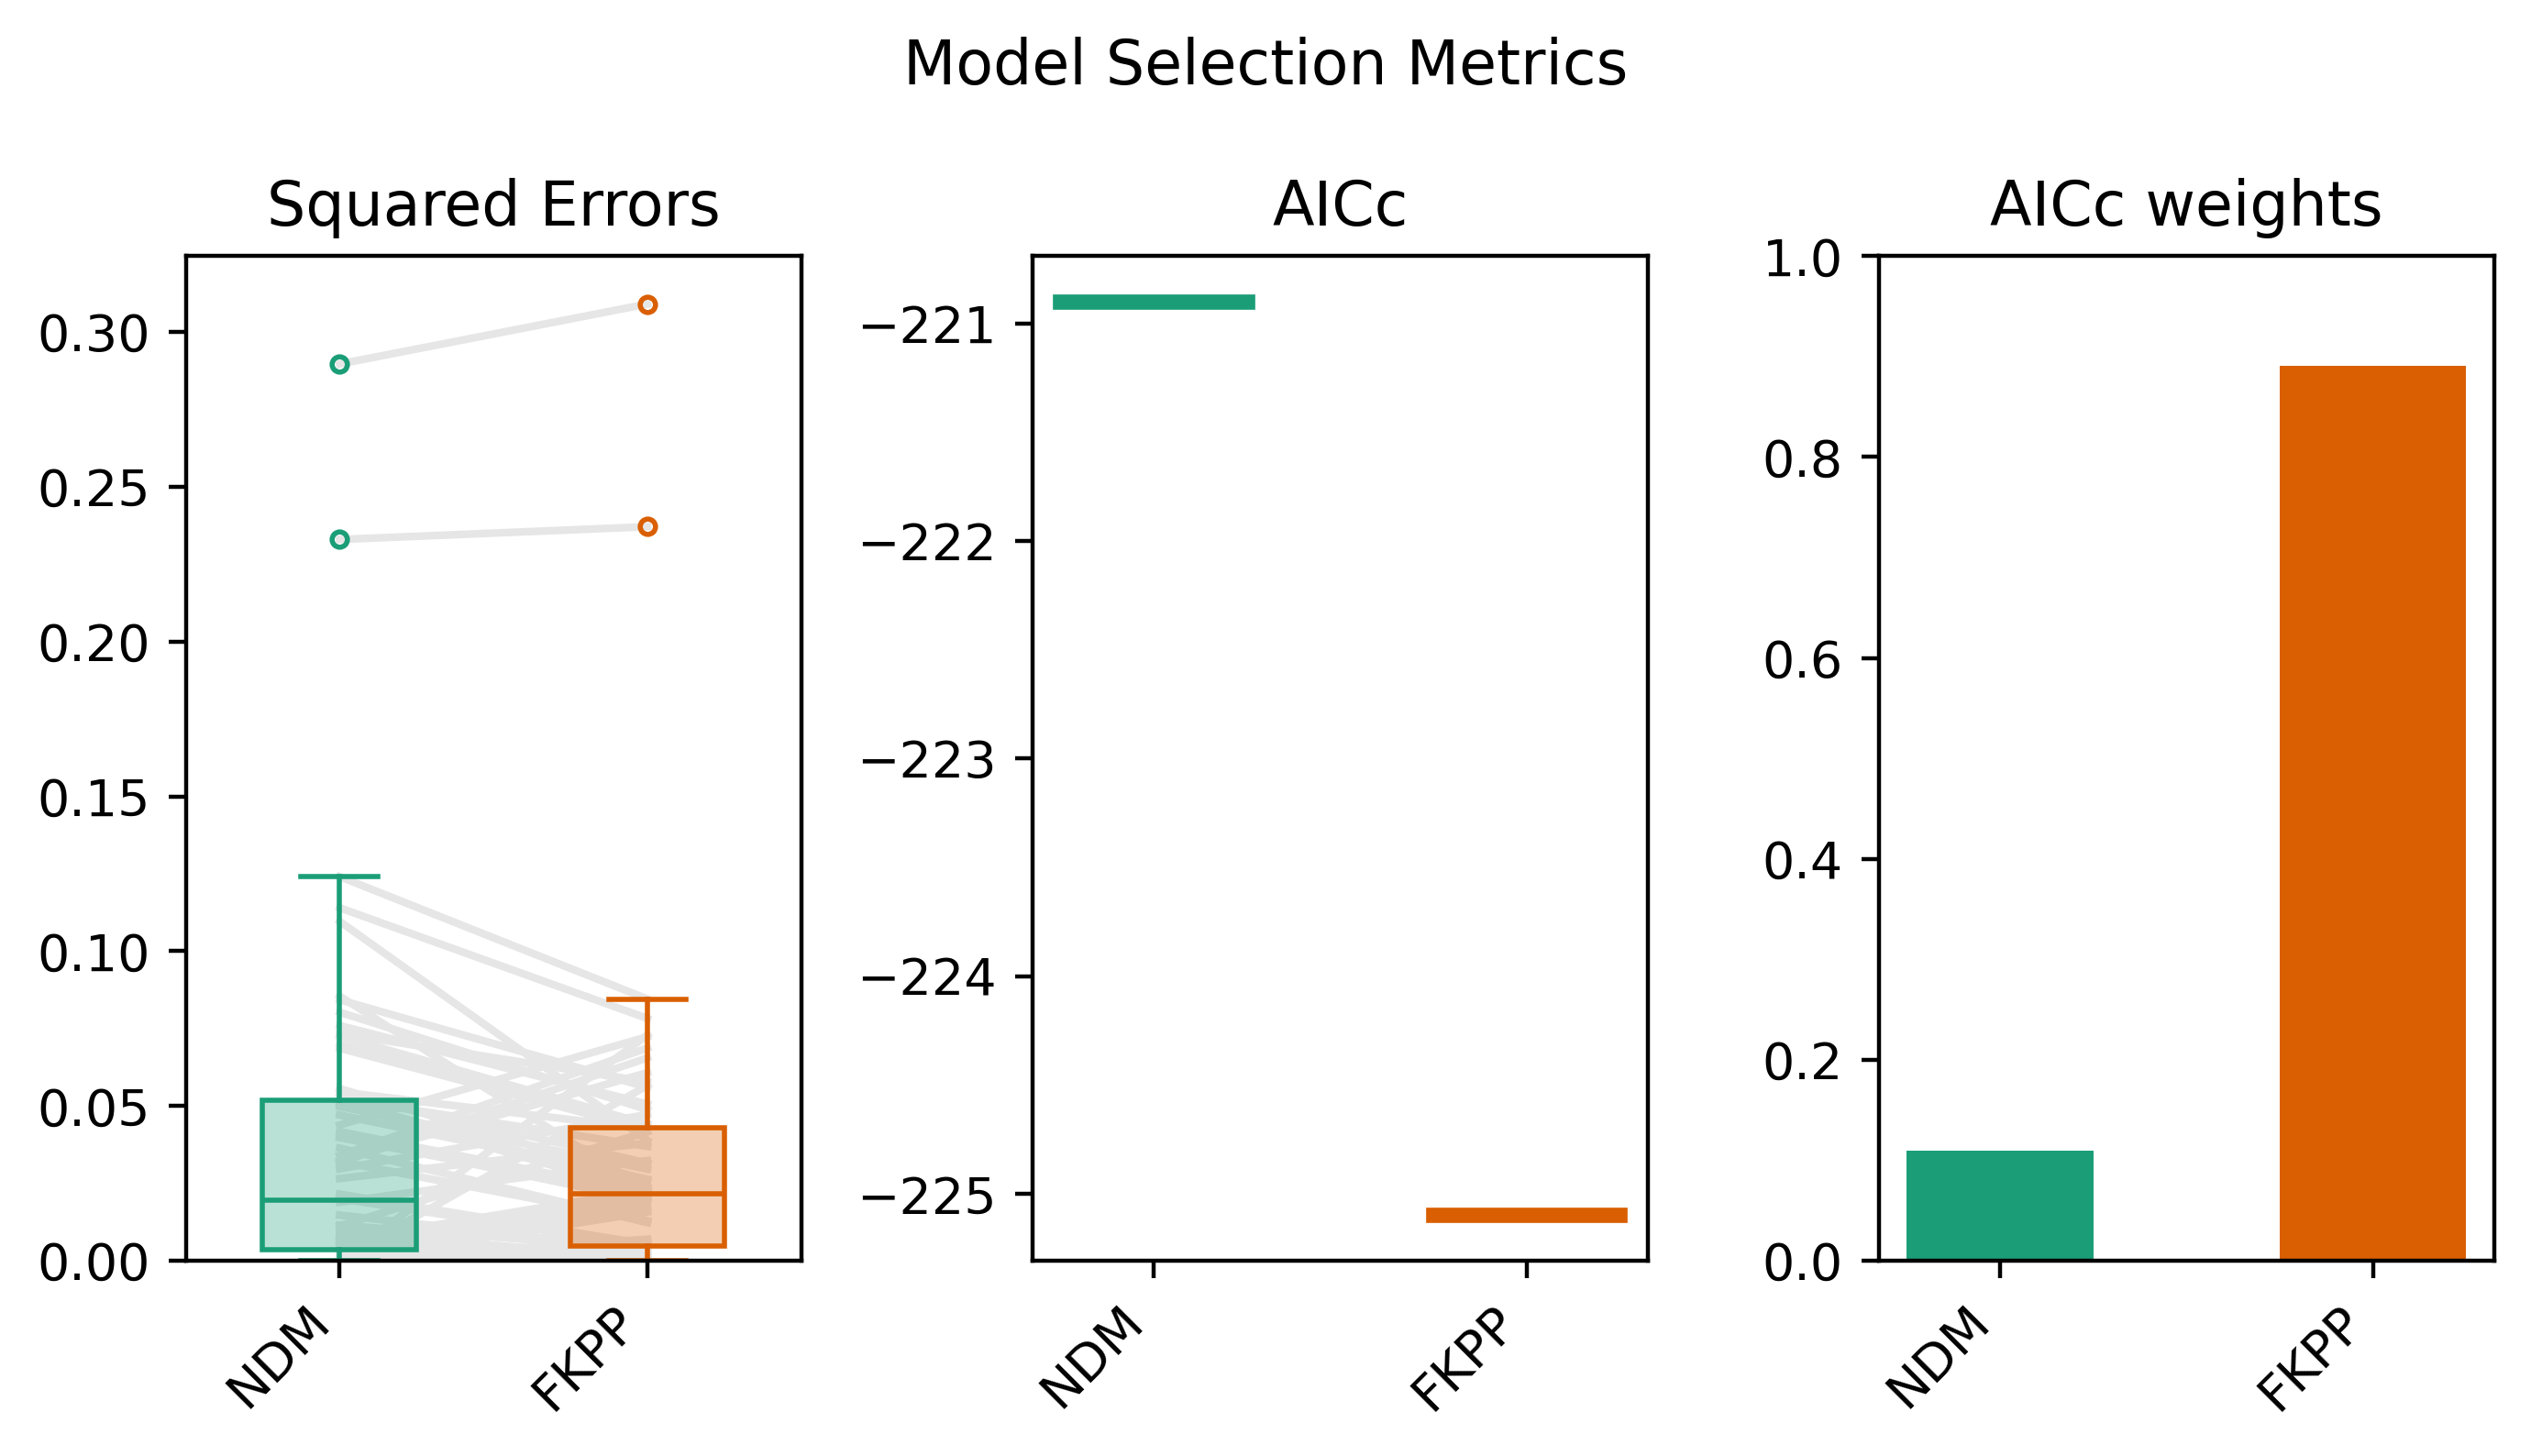

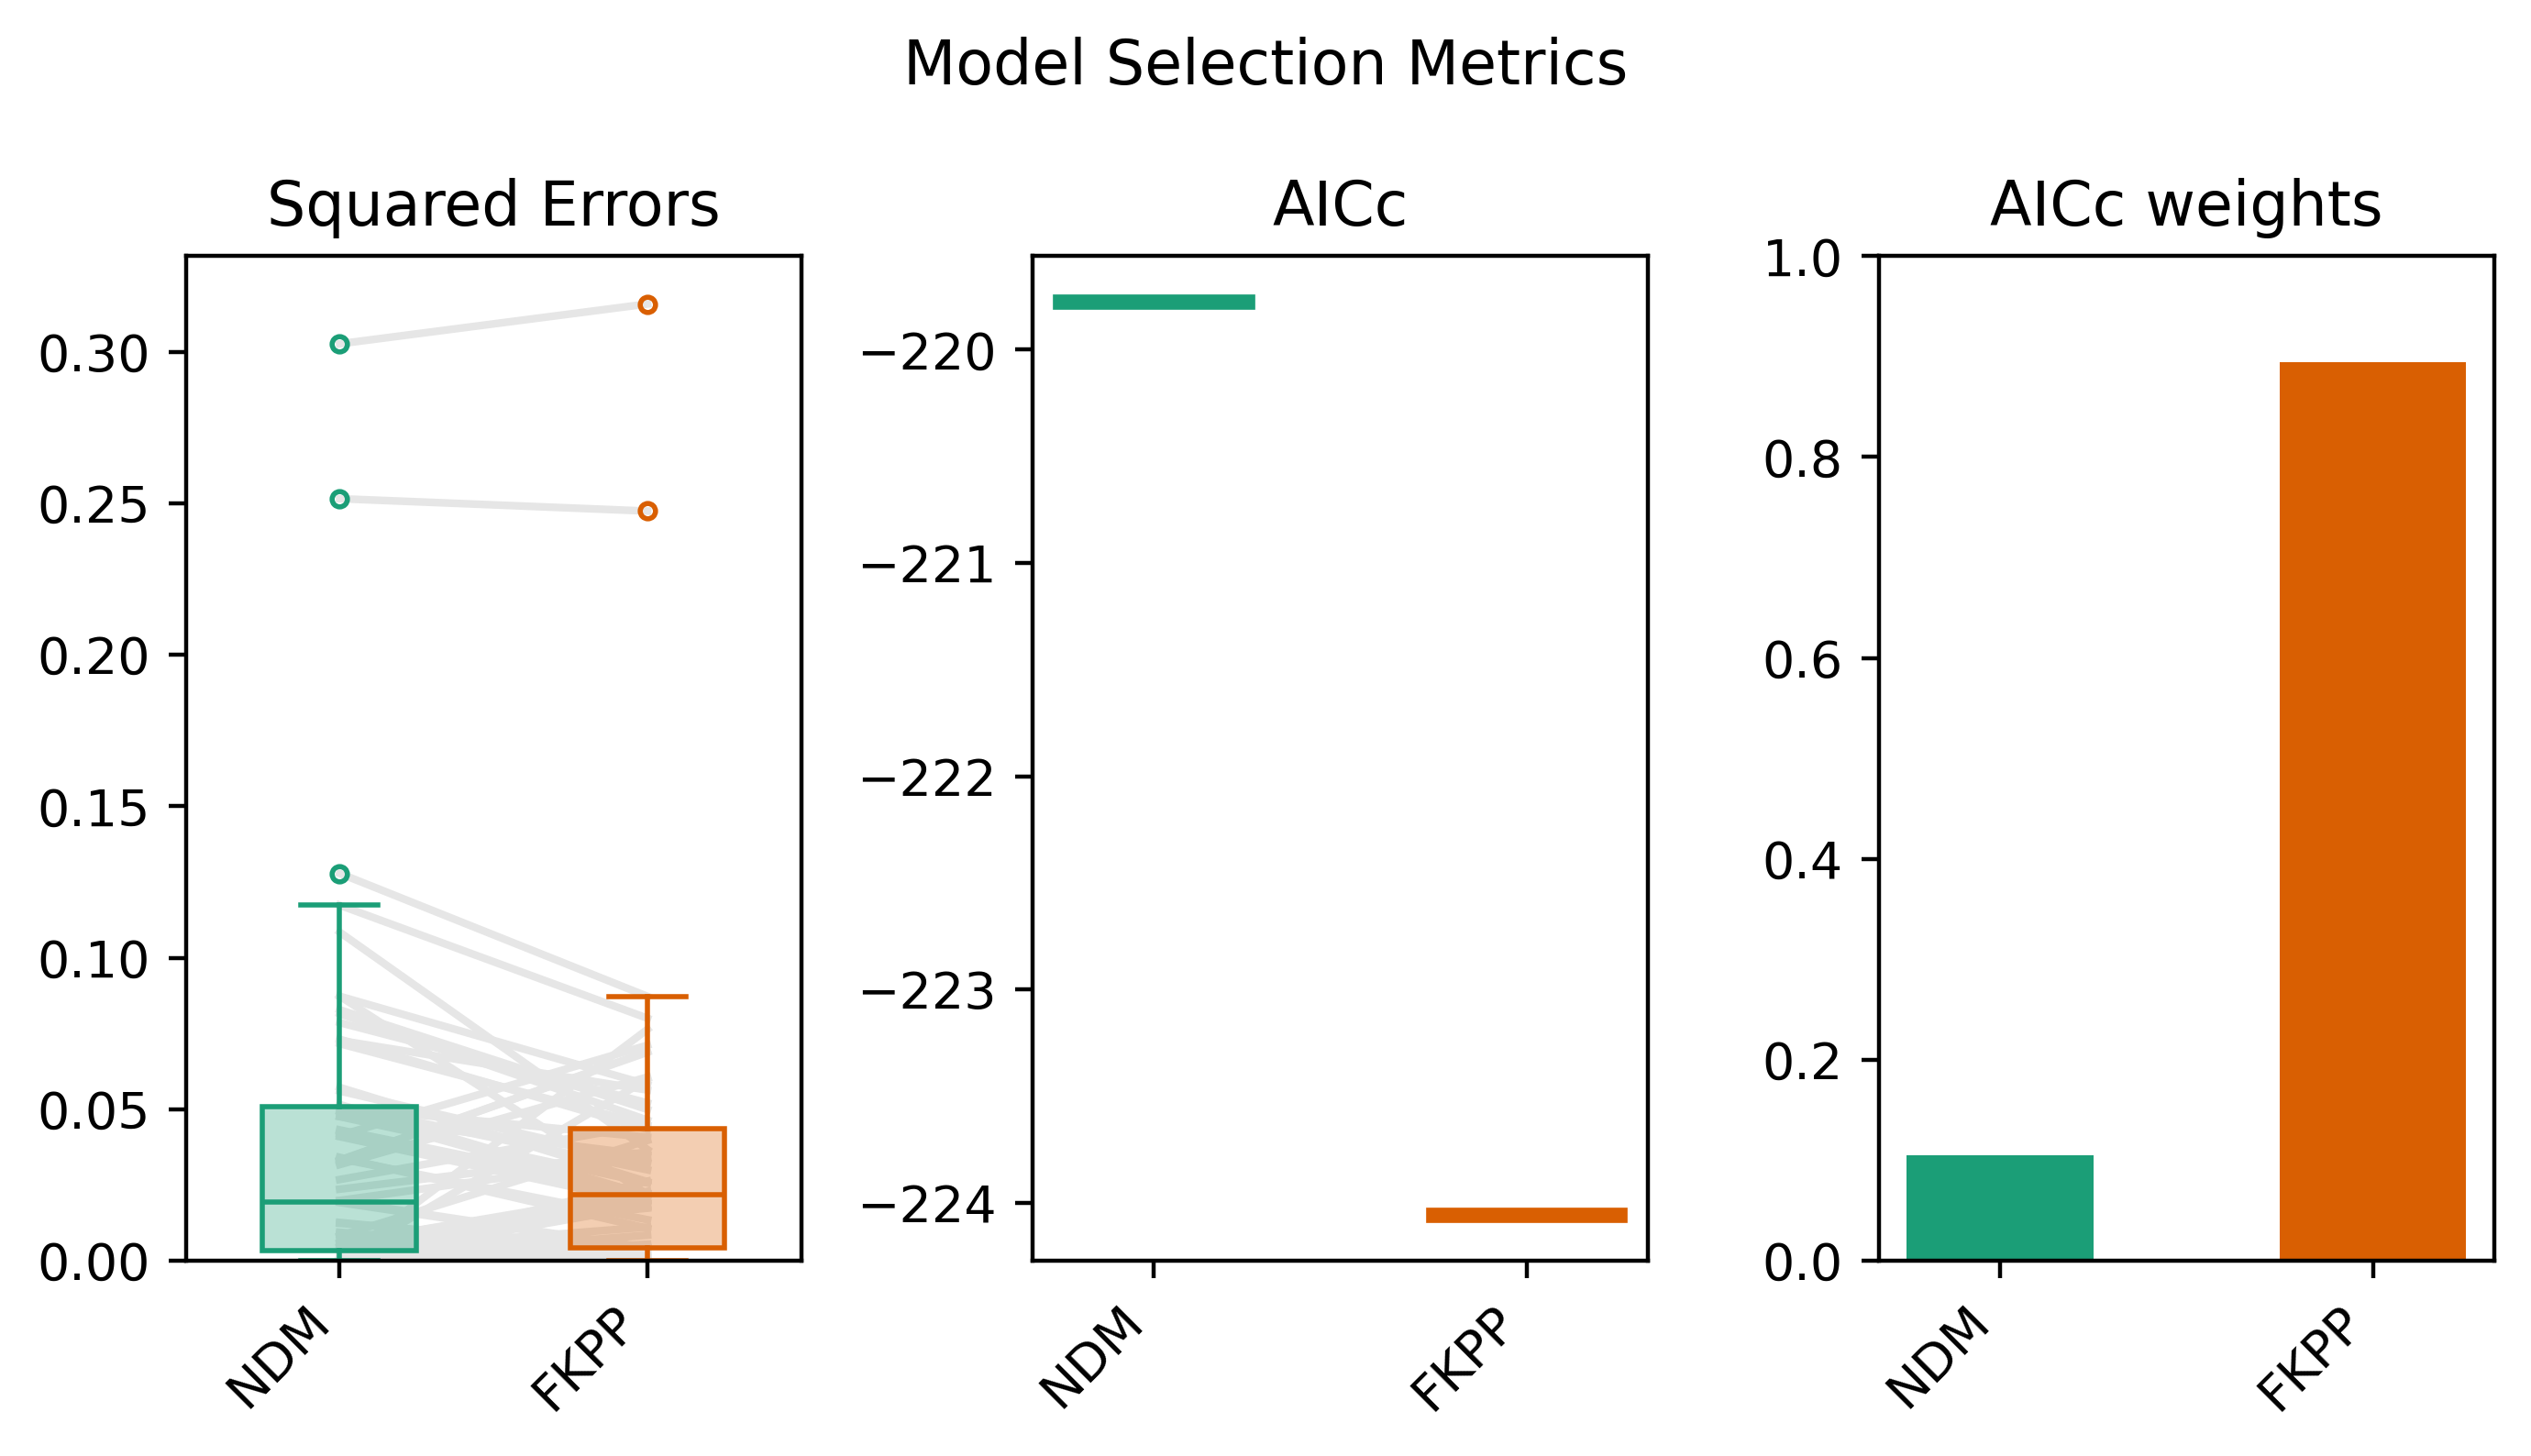

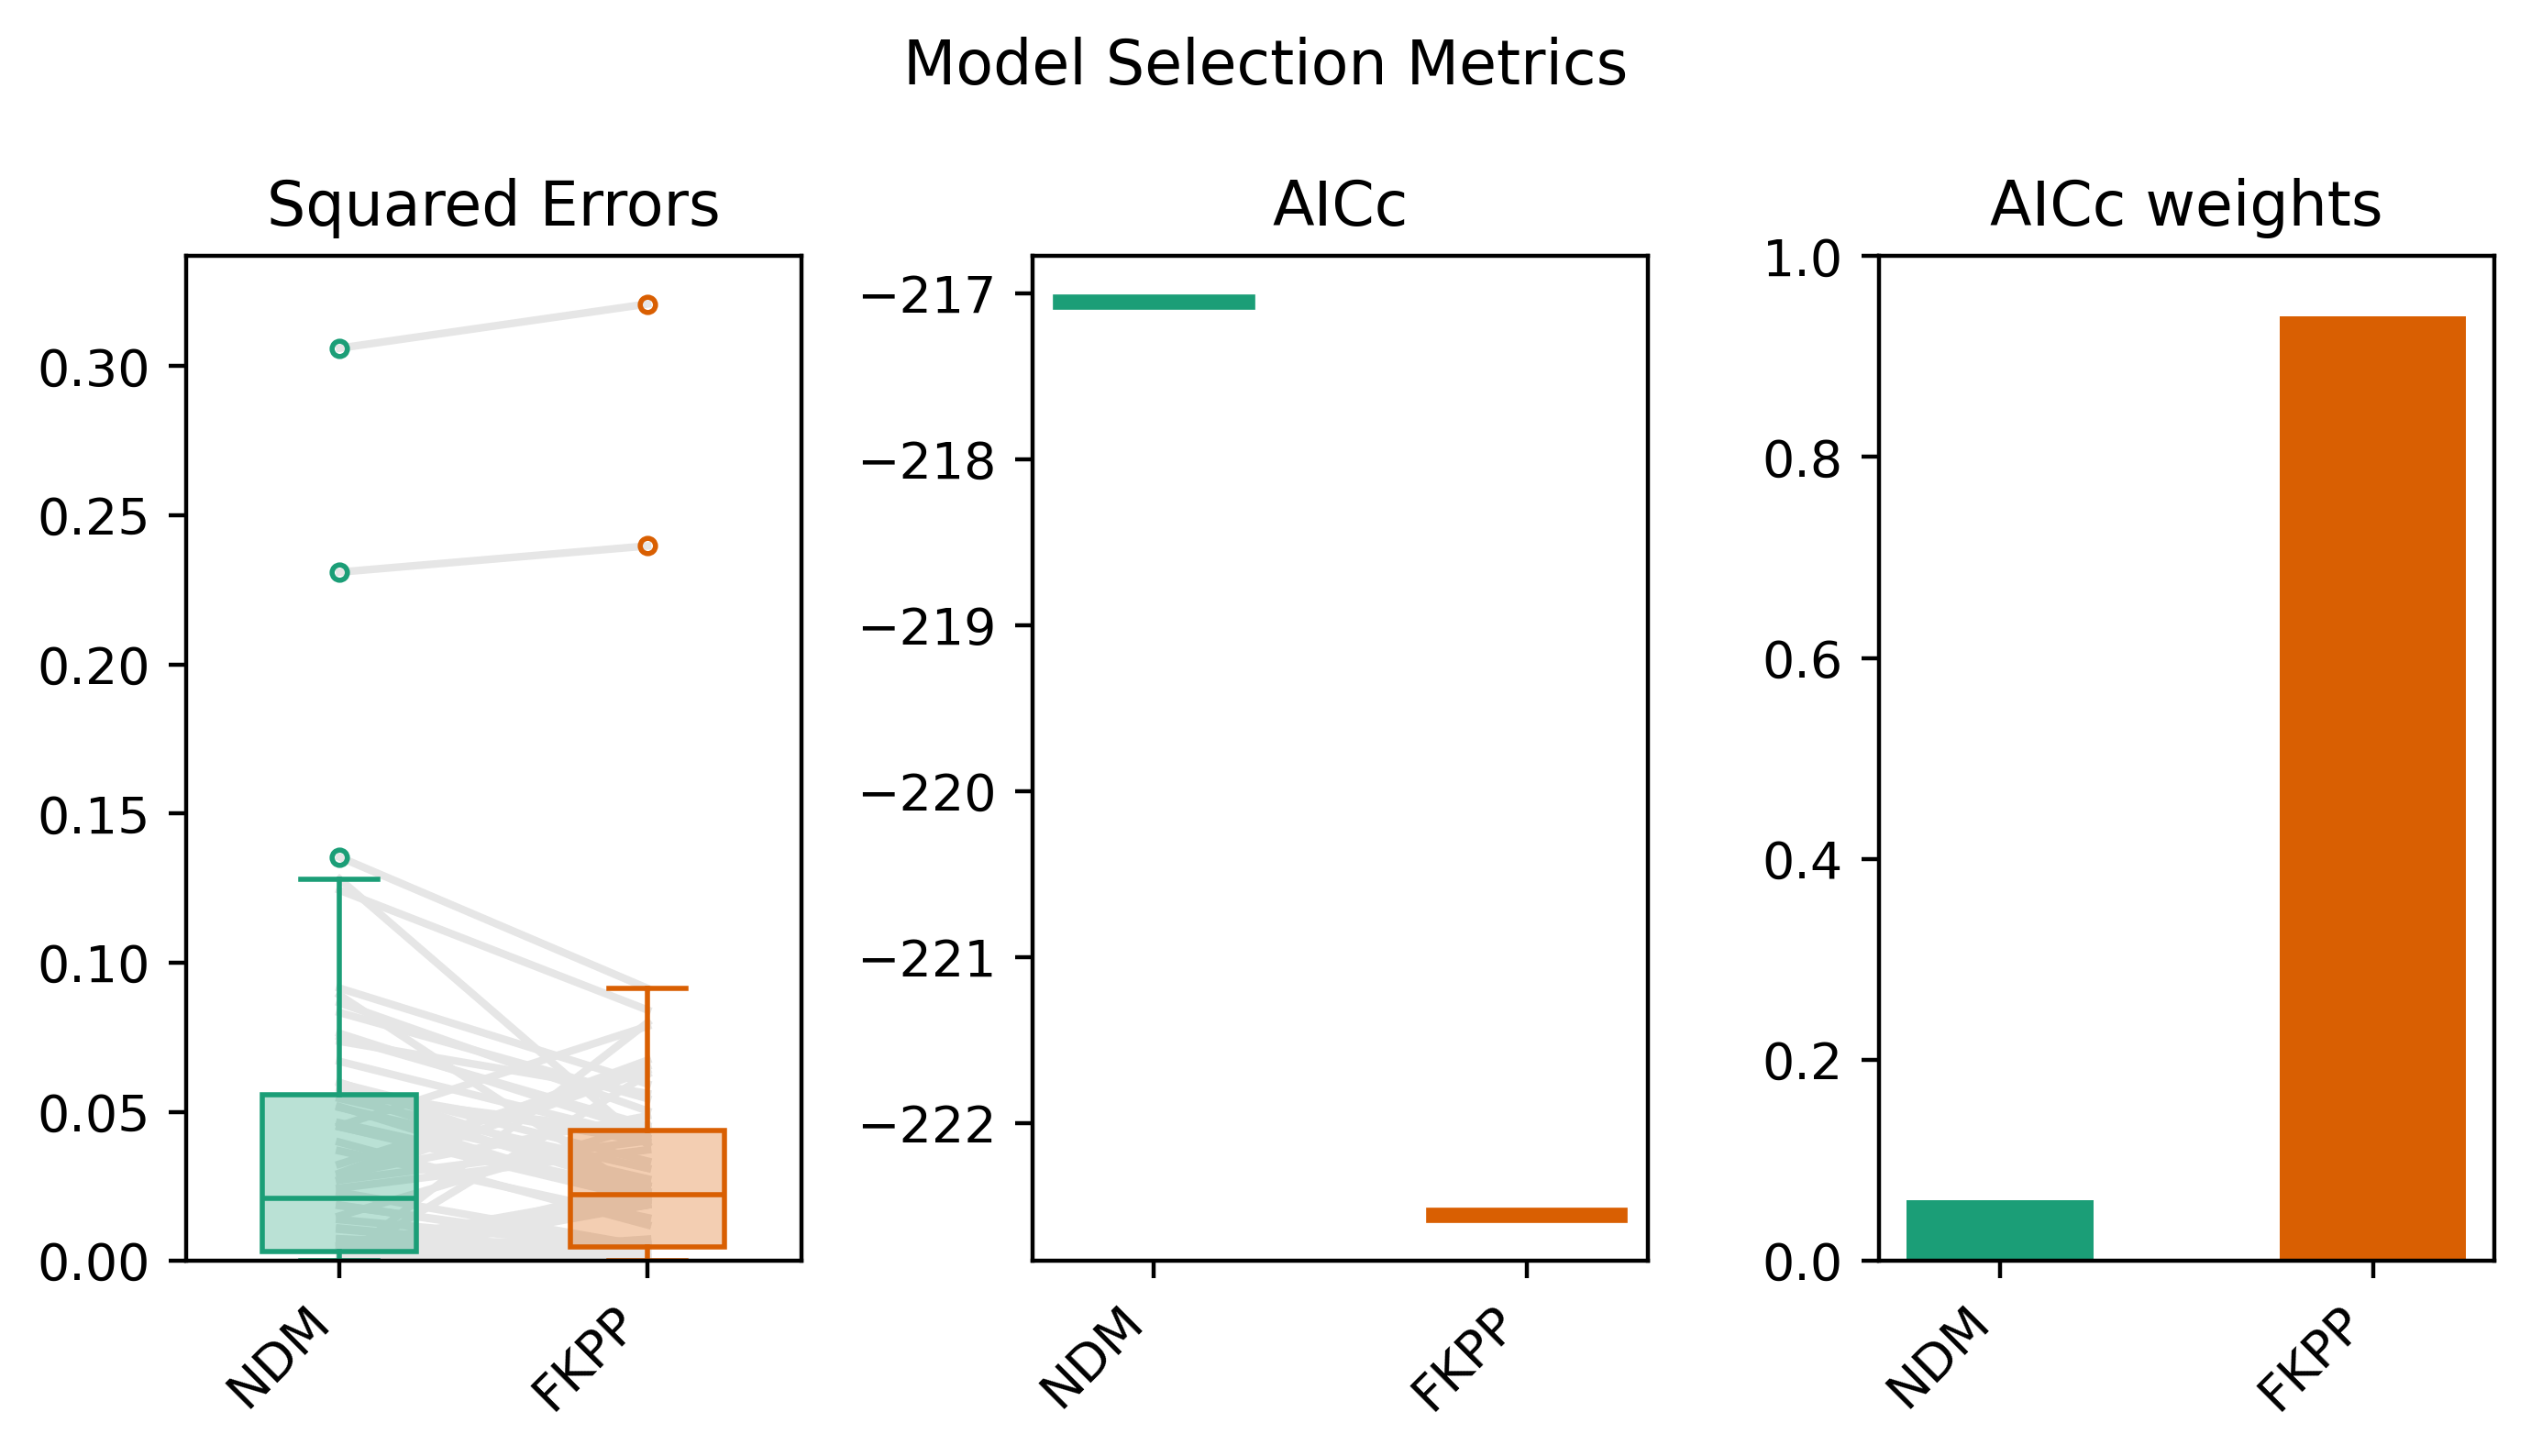

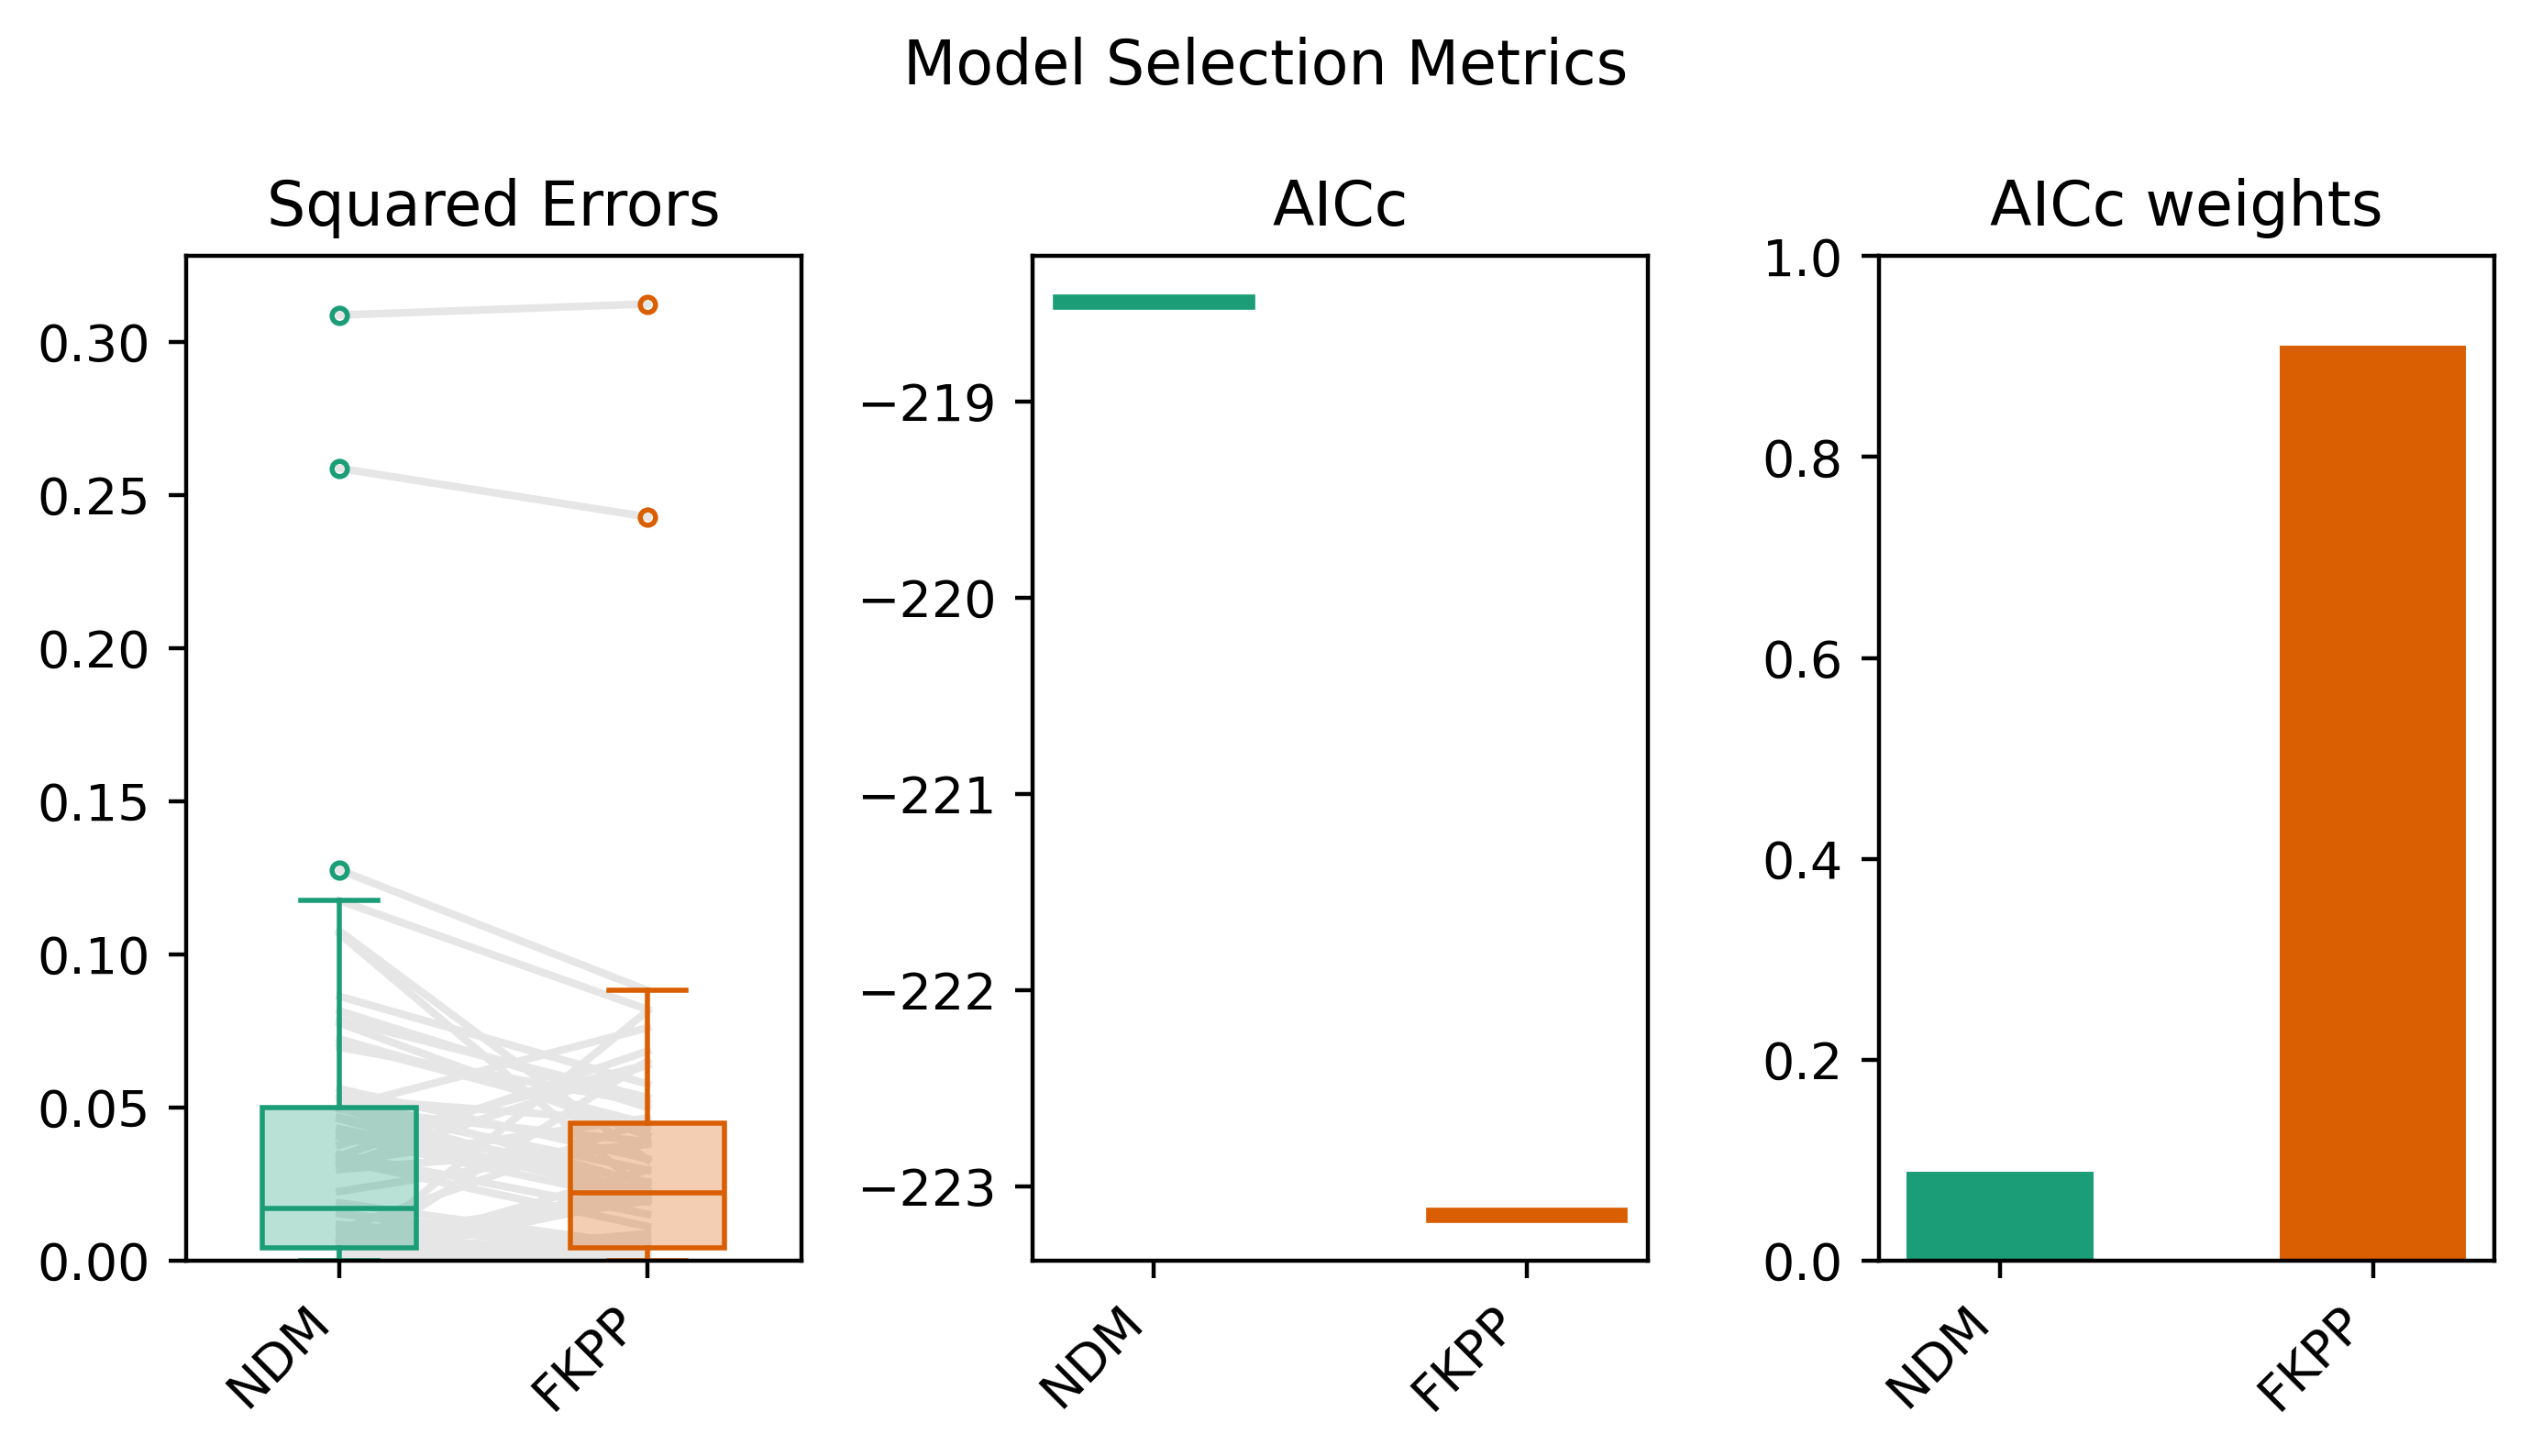

{'CN':   Model        AICc  AICc weights  rank
 0   NDM -220.901597       0.10933     2
 1  FKPP -225.096799       0.89067     1,
 'EMCI':   Model        AICc  AICc weights  rank
 0   NDM -219.775570      0.105207     2
 1  FKPP -224.056895      0.894793     1,
 'LMCI':   Model        AICc  AICc weights  rank
 0   NDM -217.050355      0.059937     2
 1  FKPP -222.555668      0.940063     1,
 'DEM':   Model        AICc  AICc weights  rank
 0   NDM -218.493878      0.088977     2
 1  FKPP -223.146266      0.911023     1}

In [6]:
def load_residuals(file_path, value_col='residual'):
    df = pd.read_csv(file_path)
    if value_col not in df.columns:
        raise ValueError(f"Column '{value_col}' not found in {file_path}. Available columns: {df.columns.tolist()}")
    values = pd.to_numeric(df[value_col], errors='coerce').values.reshape(-1, 1)
    return values

SSE_models = {}
model_selection_results = {}

for group in groups:
    ndm_residuals = load_residuals(f"data/residuals/NDM_residuals_{group}.csv", value_col='Residuals')
    fkpp_residuals = load_residuals(f"data/residuals/FKPP_residuals_{group}.csv", value_col='Residuals')

    SSE_models[group] = np.concatenate([ndm_residuals, fkpp_residuals], axis=1)

    model_selection_results[group] = ModelSelection(
        [2, 3], 'AICc', ["NDM", "FKPP"]
    )(SSE_models[group])

model_selection_results

## Visualisation

In [1]:
from enigmatoolbox.datasets import load_fsa5
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
import numpy as np
import pandas as pd

load_fsa5()

# Load one residuals file (e.g., CN)
ndm_df = pd.read_csv(f"data/residuals/NDM_residuals_CN.csv")
residuals = ndm_df["Residuals"].values

# Map to surface
surface = parcel_to_surface(residuals, 'aparc_fsa5')

plot_cortical(surface, 'fsa5',
              cmap='RdBu_r',
              color_range=(-0.5, 0.5),
              color_bar=True,
              interactive=False)

In [1]:
from enigmatoolbox.datasets import load_fsa5
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
import numpy as np
import pandas as pd

load_fsa5()

# Load one residuals file (e.g., CN)
fkpp_df = pd.read_csv(f"data/residuals/FKPP_residuals_CN.csv")
residuals = fkpp_df["Residuals"].values

# Map to surface
surface = parcel_to_surface(residuals, 'aparc_fsa5')

plot_cortical(surface, 'fsa5',
              cmap='RdBu_r',
              color_range=(-0.5, 0.5),
              color_bar=True,
              interactive=False)

In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from enigmatoolbox.datasets import load_fsa5
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical

load_fsa5()
groups = ["CN", "EMCI", "LMCI", "DEM"]

for group in groups:
    
        ndm_df = pd.read_csv(f"data/residuals/NDM_residuals_{group}.csv")
        residuals_ndm = ndm_df["Residuals"].values

        fkpp_df = pd.read_csv(f"data/residuals/FKPP_residuals_{group}.csv")
        residuals_fkpp = fkpp_df["Residuals"].values
        

        # Plot
        plot_cortical(surface_ndm, 'fsa5',
                      label_text={"text": f"{group} NDM"},
                      cmap='RdBu_r',
                      color_bar=True,
                      color_range=(-0.5, 0.5),
                      interactive=False,
                      filename=f"{group}_NDM_residuals.png")

        plot_cortical(surface_fkpp, 'fsa5',
                      label_text={"text": f"{group} FKPP"},
                      cmap='RdBu_r',
                      color_bar=True,
                      color_range=(-0.5, 0.5),
                      interactive=False,
                      filename=f"{group}_FKPP_residuals.png")

        print(f"✅ Visualizations for group {group}")

❌ Plotting failed for group CN: Incorrect row values.
❌ Plotting failed for group EMCI: Incorrect row values.
❌ Plotting failed for group LMCI: Incorrect row values.
❌ Plotting failed for group DEM: Incorrect row values.


## Individual Connectomes

In [34]:
patients = 42 #0-41

for group in groups:
    print(f"{group} Top 5 regions with lowest SSE according NDM")
    print()
    print(ndm_results[group]["df"].sort_values(by="SSE").head())

CN Top 5 regions with lowest SSE according NDM

                seed       SSE         r
28  Inferiortemporal  2.478383  0.724249
37      Temporalpole  2.641696  0.618079
14        Entorhinal  2.644907  0.597384
19          Amygdala  2.814673  0.544657
33    Middletemporal  2.900863  0.658039
EMCI Top 5 regions with lowest SSE according NDM

                seed       SSE         r
28  Inferiortemporal  2.519765  0.719243
14        Entorhinal  2.738142  0.580164
37      Temporalpole  2.767463  0.615738
19          Amygdala  2.812019  0.539256
24       Hippocampus  2.903887  0.539922
LMCI Top 5 regions with lowest SSE according NDM

                seed       SSE         r
28  Inferiortemporal  2.622800  0.717790
37      Temporalpole  2.763001  0.608399
19          Amygdala  2.768094  0.548724
14        Entorhinal  2.809329  0.585227
24       Hippocampus  2.967577  0.542361
DEM Top 5 regions with lowest SSE according NDM

                seed       SSE         r
28  Inferiortemporal  2.

In [35]:
top_regions = ["Inferiortemporal", "Amygdala", "Entorhinal", "Temporalpole", "Hippocampus", "Middletemporal"]

In [40]:
num_patients = 42

individual_results = {}
for group in groups:
    group_patient_data = []
    for i in range(patients):
        print(f"Processing NDM {group} patient {i}")
        connectome_path = f"data/connectomes/{group}/{group}_{i}.csv"
        group_patient_data.append({
            "ndm": ndm_model(group, t, gamma, target_data, region_list),
        })
        
    individual_results[group] = group_patient_data
    
def run_fkpp_for_patient(group, i, connectome_path, target_data, region_list, top_regions):
    print(f"Processing FKPP {group} patient {i}")
    fkpp_result = fkpp_model(group, t, gamma, target_data, region_list,
                             seed_list=top_regions, n_calls=100, n_initial_points=64)
    return i, fkpp_result


for group in groups:
    results = Parallel(n_jobs=4)(
        delayed(run_fkpp_for_patient)(group, i, f"data/connectomes/{group}/{group}_{i}.csv",
            target_data, region_list, top_regions)
        for i in range(num_patients))

    for i, fkpp_result in results:
        individual_results[group][i]["fkpp"] = fkpp_result

Processing NDM CN patient 0
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing NDM CN patient 1
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing NDM CN patient 2
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing NDM CN patient 3
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing NDM CN patient 4
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing NDM CN patient 5
NDM Results for group CN:
{'seed': 'Inferiortemporal'}
43
2.4783831364081523
0.7242489235133083
----------------------------------------
Processing

Traceback (most recent call last):
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/88/27mws8mx02qdqd8pk9dp1pg00000gn/T/ipykernel_24340/116050903.py", line 23, in <module>
    results = Parallel(n_jobs=4)(
              ^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/joblib/parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/joblib/parallel.py", line 1762, in _retrieve
    time.sleep(0.01)
KeyboardInterrup